## Configuration Parameters

In [ ]:
import sys
sys.path.append('../..')
sys.path.append('../../tests/kv_sampling')

from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (
    norm, uniform, expon, gamma, beta, lognorm, 
    chi2, rayleigh, pareto, weibull_min, laplace,
    cauchy, logistic, gumbel_r, kstest, anderson
)
from sklearn.mixture import GaussianMixture
from typing import List, Dict, Tuple
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 8)
sns.set_style('whitegrid')

print("Libraries imported successfully!")

/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Libraries imported successfully!


In [ ]:
# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Real data parameters
REAL_DATA_PATH = '../../tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251217_002021.npz'

# Analysis parameters
MAX_KEYS = 10_000  # Subsample for faster analysis
NUM_DIMENSIONS_TO_ANALYZE = 10  # Analyze first N dimensions in detail

# Mixture of Gaussians parameters to test
GMM_COMPONENTS_RANGE = [2, 3, 5, 8, 10]  # Different number of components to try

# Output
FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration:")
print(f"  Real data path: {REAL_DATA_PATH}")
print(f"  Max keys to analyze: {MAX_KEYS}")
print(f"  Dimensions to analyze in detail: {NUM_DIMENSIONS_TO_ANALYZE}")
print(f"  GMM components to test: {GMM_COMPONENTS_RANGE}")
print(f"  Figures directory: {FIGURES_DIR.resolve()}")

Configuration:
  Real data path: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251217_002021.npz
  Max keys to analyze: 10000
  Dimensions to analyze in detail: 10
  GMM components to test: [2, 3, 5, 8, 10]
  Figures directory: /home/mohsen/kvcache/hira/tests/pruning/notebooks/figures


## Load Real KV Cache Data

In [3]:
# Load real KV cache data
print(f"Loading real data from: {REAL_DATA_PATH}")
data = np.load(REAL_DATA_PATH)
keys = torch.from_numpy(data['keys']).float()

print(f"\nOriginal data:")
print(f"  Shape: {keys.shape}")
print(f"  Dtype: {keys.dtype}")
print(f"  Device: {keys.device}")

# Subsample if needed
if len(keys) > MAX_KEYS:
    indices = torch.randperm(len(keys))[:MAX_KEYS]
    keys = keys[indices]
    print(f"\nSubsampled to {len(keys)} keys")

num_keys, dimension = keys.shape
print(f"\nFinal data:")
print(f"  Number of keys: {num_keys}")
print(f"  Dimension: {dimension}")

Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251217_002021.npz

Original data:
  Shape: torch.Size([10000, 128])
  Dtype: torch.float32
  Device: cpu

Final data:
  Number of keys: 10000
  Dimension: 128


## Basic Statistical Analysis

In [4]:
# Compute basic statistics
keys_np = keys.numpy()

print("="*80)
print("BASIC STATISTICS")
print("="*80)

# Global statistics (across all dimensions)
print("\nGlobal Statistics (all dimensions):")
print(f"  Mean: {keys_np.mean():.6f}")
print(f"  Std: {keys_np.std():.6f}")
print(f"  Min: {keys_np.min():.6f}")
print(f"  Max: {keys_np.max():.6f}")
print(f"  Median: {np.median(keys_np):.6f}")

# Per-dimension statistics
dim_means = keys_np.mean(axis=0)
dim_stds = keys_np.std(axis=0)
dim_mins = keys_np.min(axis=0)
dim_maxs = keys_np.max(axis=0)

print("\nPer-Dimension Statistics:")
print(f"  Mean of means: {dim_means.mean():.6f} ± {dim_means.std():.6f}")
print(f"  Mean of stds: {dim_stds.mean():.6f} ± {dim_stds.std():.6f}")

# Compute norms
norms = torch.norm(keys, dim=1).numpy()
print("\nVector Norms:")
print(f"  Mean norm: {norms.mean():.6f}")
print(f"  Std norm: {norms.std():.6f}")
print(f"  Min norm: {norms.min():.6f}")
print(f"  Max norm: {norms.max():.6f}")

# Skewness and Kurtosis
from scipy.stats import skew, kurtosis
print("\nDistribution Shape:")
print(f"  Skewness (global): {skew(keys_np.flatten()):.6f}")
print(f"  Kurtosis (global): {kurtosis(keys_np.flatten()):.6f}")

BASIC STATISTICS

Global Statistics (all dimensions):
  Mean: -0.021708
  Std: 1.726372
  Min: -17.000000
  Max: 15.312500
  Median: -0.002167

Per-Dimension Statistics:
  Mean of means: -0.021708 ± 0.558699
  Mean of stds: 1.431307 ± 0.787129

Vector Norms:
  Mean norm: 18.751026
  Std norm: 5.472219
  Min norm: 1.936918
  Max norm: 27.461456

Distribution Shape:
  Skewness (global): -1.025751
  Kurtosis (global): 19.028177


## Visualize Data Distribution

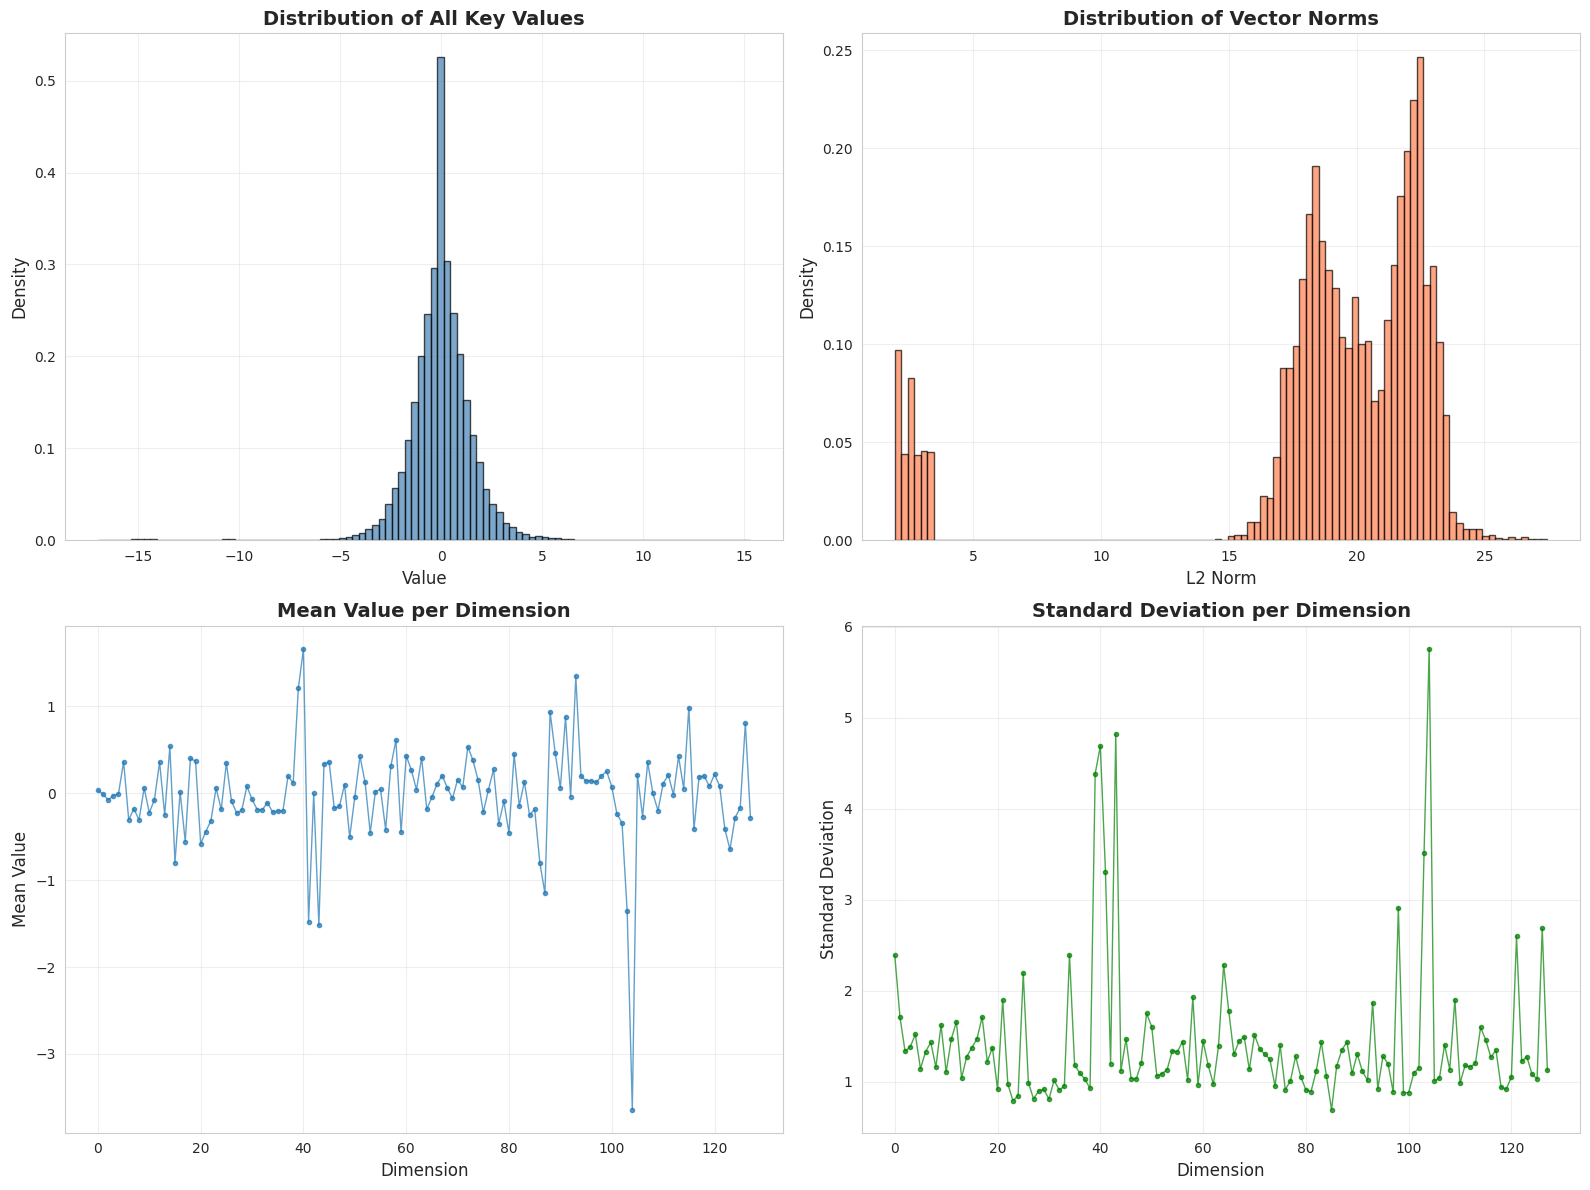

In [5]:
# Plot 1: Distribution of all values
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# All values histogram
ax1 = axes[0, 0]
ax1.hist(keys_np.flatten(), bins=100, alpha=0.7, edgecolor='black', color='steelblue', density=True)
ax1.set_xlabel('Value', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution of All Key Values', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Vector norms histogram
ax2 = axes[0, 1]
ax2.hist(norms, bins=100, alpha=0.7, edgecolor='black', color='coral', density=True)
ax2.set_xlabel('L2 Norm', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Distribution of Vector Norms', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Per-dimension means
ax3 = axes[1, 0]
ax3.plot(dim_means, marker='o', linewidth=1, markersize=3, alpha=0.7)
ax3.set_xlabel('Dimension', fontsize=12)
ax3.set_ylabel('Mean Value', fontsize=12)
ax3.set_title('Mean Value per Dimension', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Per-dimension stds
ax4 = axes[1, 1]
ax4.plot(dim_stds, marker='o', linewidth=1, markersize=3, alpha=0.7, color='green')
ax4.set_xlabel('Dimension', fontsize=12)
ax4.set_ylabel('Standard Deviation', fontsize=12)
ax4.set_title('Standard Deviation per Dimension', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'real_data_overview.png', dpi=300, bbox_inches='tight')
plt.show()

## Fit Single-Variable Distributions

In [6]:
# Define distributions to test
distributions_to_test = [
    ('Normal', norm),
    ('Uniform', uniform),
    ('Exponential', expon),
    ('Gamma', gamma),
    ('Log-Normal', lognorm),
    ('Laplace', laplace),
    ('Cauchy', cauchy),
    ('Logistic', logistic),
    ('Rayleigh', rayleigh),
    ('Weibull', weibull_min),
    ('Gumbel', gumbel_r),
]

print(f"Testing {len(distributions_to_test)} distributions...\n")

Testing 11 distributions...



In [7]:
# Fit distributions and compute goodness of fit
def fit_distribution(data, dist_name, dist_func):
    """
    Fit a distribution to data and compute goodness of fit metrics.
    
    Returns:
        dict with fit parameters and metrics
    """
    try:
        # Fit distribution
        params = dist_func.fit(data)
        
        # Kolmogorov-Smirnov test
        ks_stat, ks_pvalue = kstest(data, lambda x: dist_func.cdf(x, *params))
        
        # Anderson-Darling test (only for some distributions)
        ad_stat = None
        try:
            if dist_name.lower() in ['normal', 'exponential', 'logistic', 'gumbel']:
                ad_result = anderson(data, dist=dist_name.lower())
                ad_stat = ad_result.statistic
        except:
            pass
        
        # Compute negative log-likelihood
        nll = -np.sum(dist_func.logpdf(data, *params))
        
        # Compute AIC and BIC
        k = len(params)  # Number of parameters
        n = len(data)
        aic = 2 * k + 2 * nll
        bic = k * np.log(n) + 2 * nll
        
        return {
            'name': dist_name,
            'params': params,
            'ks_stat': ks_stat,
            'ks_pvalue': ks_pvalue,
            'ad_stat': ad_stat,
            'nll': nll,
            'aic': aic,
            'bic': bic,
            'success': True
        }
    except Exception as e:
        return {
            'name': dist_name,
            'success': False,
            'error': str(e)
        }

# Fit all distributions to flattened data
print("="*80)
print("FITTING DISTRIBUTIONS TO ALL KEY VALUES")
print("="*80)

all_values = keys_np.flatten()
fit_results = []

for dist_name, dist_func in tqdm(distributions_to_test, desc="Fitting distributions"):
    result = fit_distribution(all_values, dist_name, dist_func)
    if result['success']:
        fit_results.append(result)
        print(f"\n{dist_name}:")
        print(f"  KS statistic: {result['ks_stat']:.6f} (p-value: {result['ks_pvalue']:.6e})")
        if result['ad_stat'] is not None:
            print(f"  AD statistic: {result['ad_stat']:.6f}")
        print(f"  AIC: {result['aic']:.2f}")
        print(f"  BIC: {result['bic']:.2f}")
    else:
        print(f"\n{dist_name}: FAILED - {result.get('error', 'Unknown error')}")

# Sort by AIC (lower is better)
fit_results.sort(key=lambda x: x['aic'])

print("\n" + "="*80)
print("RANKING BY AIC (lower is better):")
print("="*80)
for i, result in enumerate(fit_results, 1):
    print(f"{i}. {result['name']:20s} - AIC: {result['aic']:12.2f}, BIC: {result['bic']:12.2f}, KS: {result['ks_stat']:.6f}")

FITTING DISTRIBUTIONS TO ALL KEY VALUES


Fitting distributions:   9%|▉         | 1/11 [00:00<00:01,  7.08it/s]


Normal:
  KS statistic: 0.086730 (p-value: 0.000000e+00)
  AIC: 5030302.54
  BIC: 5030326.66


Fitting distributions:  18%|█▊        | 2/11 [00:00<00:01,  7.17it/s]


Uniform:
  KS statistic: 0.410821 (p-value: 0.000000e+00)
  AIC: 8897166.63
  BIC: 8897190.75


Fitting distributions:  27%|██▋       | 3/11 [00:00<00:01,  7.03it/s]


Exponential:
  KS statistic: 0.538030 (p-value: 0.000000e+00)
  AIC: 9809759.07
  BIC: 9809783.19


Fitting distributions:  36%|███▋      | 4/11 [00:04<00:13,  1.86s/it]


Gamma:
  KS statistic: 0.086847 (p-value: 0.000000e+00)
  AIC: 5154286.06
  BIC: 5154322.25


Fitting distributions:  55%|█████▍    | 6/11 [00:14<00:15,  3.07s/it]


Log-Normal:
  KS statistic: 0.086319 (p-value: 0.000000e+00)
  AIC: 5042837.78
  BIC: 5042873.96

Laplace:
  KS statistic: 0.027321 (p-value: 0.000000e+00)
  AIC: 4534683.25
  BIC: 4534707.38


Fitting distributions:  64%|██████▎   | 7/11 [00:14<00:08,  2.20s/it]


Cauchy:
  KS statistic: 0.047585 (p-value: 0.000000e+00)
  AIC: 4697011.04
  BIC: 4697035.16


Fitting distributions:  82%|████████▏ | 9/11 [00:16<00:02,  1.41s/it]


Logistic:
  KS statistic: 0.038641 (p-value: 0.000000e+00)
  AD statistic: 2190656.168643
  AIC: 4633190.77
  BIC: 4633214.90

Rayleigh:
  KS statistic: 0.474779 (p-value: 0.000000e+00)
  AIC: 8079603.89
  BIC: 8079628.01


Fitting distributions:  91%|█████████ | 10/11 [00:20<00:02,  2.14s/it]


Weibull:
  KS statistic: 0.170343 (p-value: 0.000000e+00)
  AIC: 5435275.07
  BIC: 5435311.26


Fitting distributions: 100%|██████████| 11/11 [00:20<00:00,  1.87s/it]


Gumbel:
  KS statistic: 0.255882 (p-value: 0.000000e+00)
  AD statistic: 137105.135793
  AIC: 6321135.92
  BIC: 6321160.05

RANKING BY AIC (lower is better):
1. Laplace              - AIC:   4534683.25, BIC:   4534707.38, KS: 0.027321
2. Logistic             - AIC:   4633190.77, BIC:   4633214.90, KS: 0.038641
3. Cauchy               - AIC:   4697011.04, BIC:   4697035.16, KS: 0.047585
4. Normal               - AIC:   5030302.54, BIC:   5030326.66, KS: 0.086730
5. Log-Normal           - AIC:   5042837.78, BIC:   5042873.96, KS: 0.086319
6. Gamma                - AIC:   5154286.06, BIC:   5154322.25, KS: 0.086847
7. Weibull              - AIC:   5435275.07, BIC:   5435311.26, KS: 0.170343
8. Gumbel               - AIC:   6321135.92, BIC:   6321160.05, KS: 0.255882
9. Rayleigh             - AIC:   8079603.89, BIC:   8079628.01, KS: 0.474779
10. Uniform              - AIC:   8897166.63, BIC:   8897190.75, KS: 0.410821
11. Exponential          - AIC:   9809759.07, BIC:   9809783.19, KS: 0

## Visualize Best Fitting Distributions

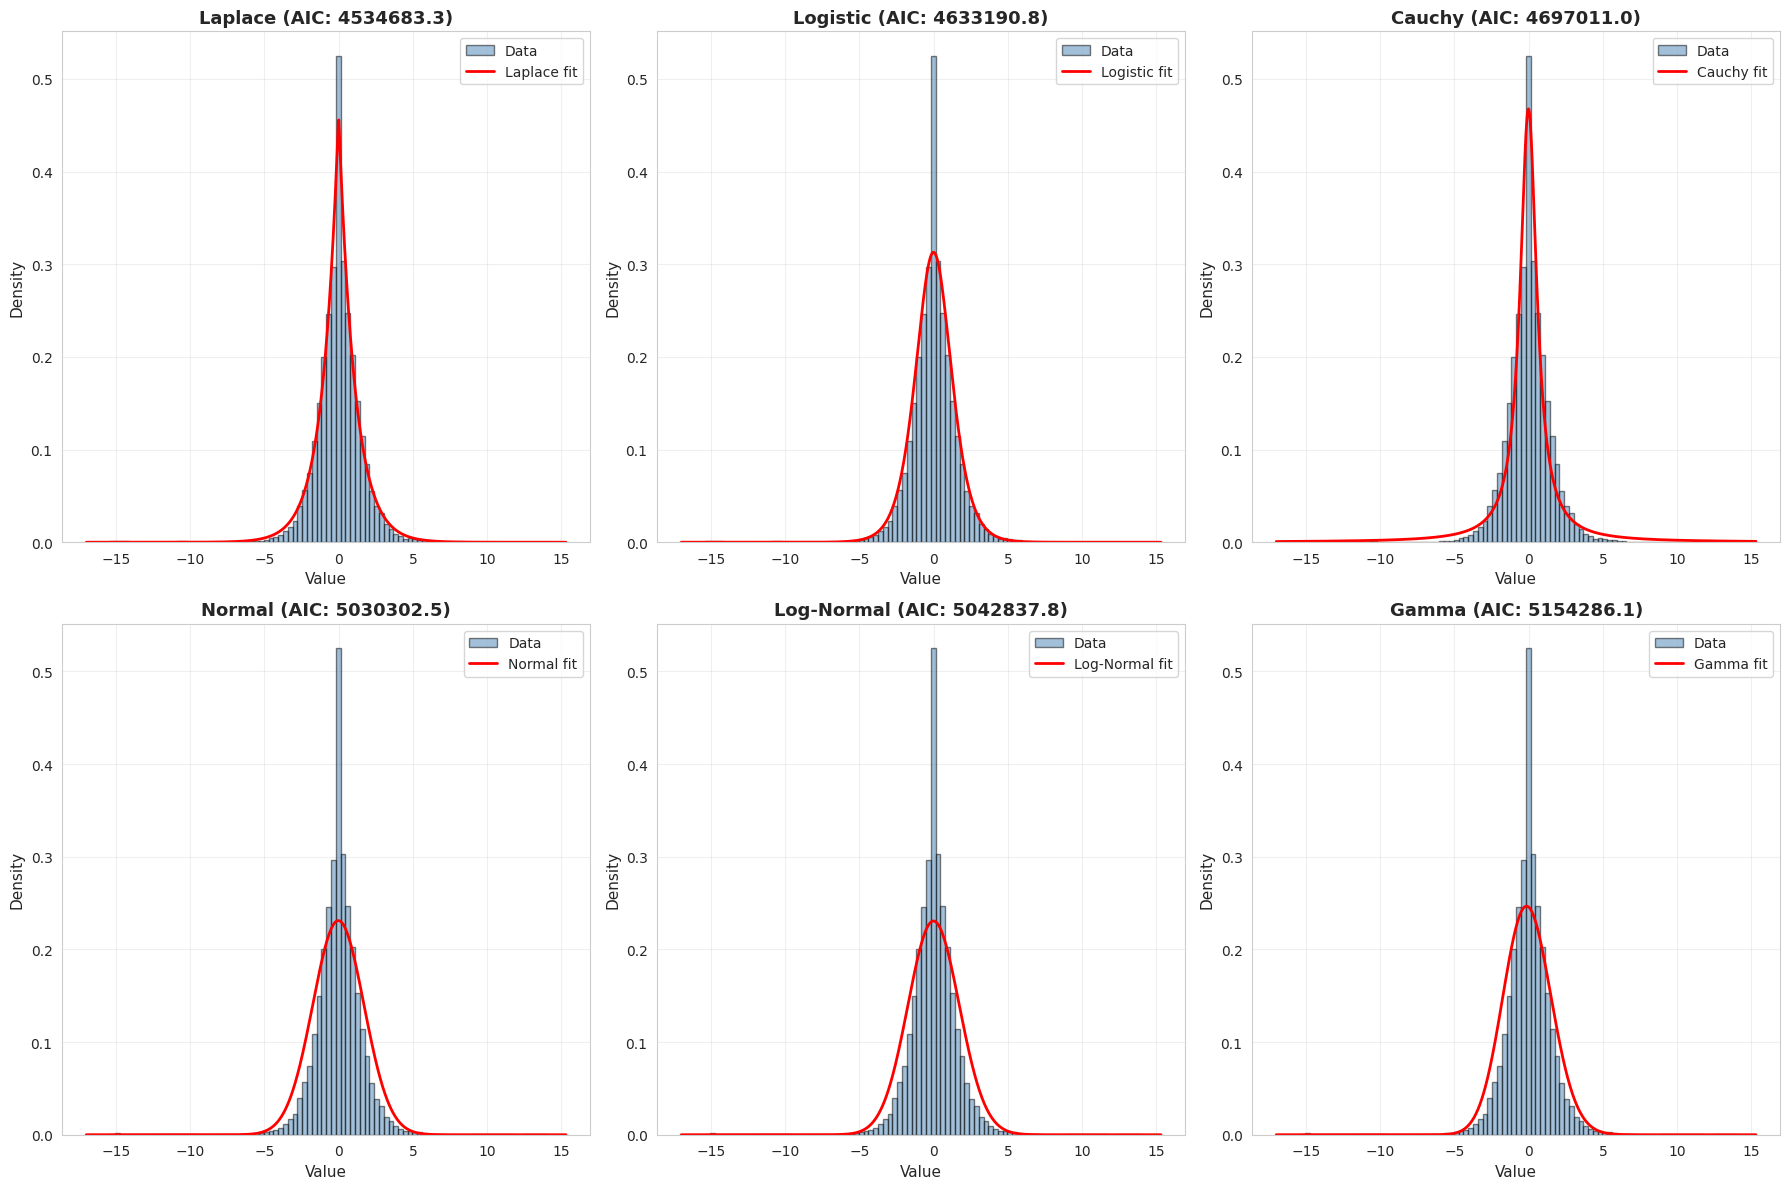

In [8]:
# Plot top 6 best-fitting distributions
top_n = min(6, len(fit_results))
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx in range(top_n):
    ax = axes[idx]
    result = fit_results[idx]
    
    # Plot histogram
    ax.hist(all_values, bins=100, alpha=0.5, density=True, color='steelblue', edgecolor='black', label='Data')
    
    # Plot fitted distribution
    x = np.linspace(all_values.min(), all_values.max(), 1000)
    dist_func = dict(distributions_to_test)[result['name']]
    y = dist_func.pdf(x, *result['params'])
    ax.plot(x, y, 'r-', linewidth=2, label=f"{result['name']} fit")
    
    ax.set_xlabel('Value', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f"{result['name']} (AIC: {result['aic']:.1f})", fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(top_n, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'top_distributions_fit.png', dpi=300, bbox_inches='tight')
plt.show()

## Fit Gaussian Mixture Models

In [9]:
# Fit GMMs with different numbers of components
print("="*80)
print("FITTING GAUSSIAN MIXTURE MODELS")
print("="*80)

gmm_results = []
all_values_reshaped = all_values.reshape(-1, 1)

for n_components in tqdm(GMM_COMPONENTS_RANGE, desc="Fitting GMMs"):
    gmm = GaussianMixture(n_components=n_components, random_state=42, max_iter=200)
    gmm.fit(all_values_reshaped)
    
    # Compute AIC and BIC
    aic = gmm.aic(all_values_reshaped)
    bic = gmm.bic(all_values_reshaped)
    log_likelihood = gmm.score(all_values_reshaped) * len(all_values)
    
    gmm_results.append({
        'n_components': n_components,
        'aic': aic,
        'bic': bic,
        'log_likelihood': log_likelihood,
        'gmm': gmm
    })
    
    print(f"\nGMM with {n_components} components:")
    print(f"  AIC: {aic:.2f}")
    print(f"  BIC: {bic:.2f}")
    print(f"  Log-likelihood: {log_likelihood:.2f}")

# Sort by AIC
gmm_results.sort(key=lambda x: x['aic'])

print("\n" + "="*80)
print("GMM RANKING BY AIC:")
print("="*80)
for i, result in enumerate(gmm_results, 1):
    print(f"{i}. {result['n_components']} components - AIC: {result['aic']:12.2f}, BIC: {result['bic']:12.2f}")

FITTING GAUSSIAN MIXTURE MODELS


Fitting GMMs:  20%|██        | 1/5 [00:02<00:10,  2.53s/it]


GMM with 2 components:
  AIC: 4554106.98
  BIC: 4554167.30
  Log-likelihood: -2277048.49


Fitting GMMs:  40%|████      | 2/5 [00:04<00:07,  2.34s/it]


GMM with 3 components:
  AIC: 4508741.59
  BIC: 4508838.08
  Log-likelihood: -2254362.79


Fitting GMMs:  60%|██████    | 3/5 [00:06<00:04,  2.23s/it]


GMM with 5 components:
  AIC: 4504661.48
  BIC: 4504830.36
  Log-likelihood: -2252316.74


Fitting GMMs:  80%|████████  | 4/5 [00:09<00:02,  2.28s/it]


GMM with 8 components:
  AIC: 4482640.91
  BIC: 4482918.34
  Log-likelihood: -2241297.45


Fitting GMMs: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


GMM with 10 components:
  AIC: 4466050.13
  BIC: 4466399.94
  Log-likelihood: -2232996.06

GMM RANKING BY AIC:
1. 10 components - AIC:   4466050.13, BIC:   4466399.94
2. 8 components - AIC:   4482640.91, BIC:   4482918.34
3. 5 components - AIC:   4504661.48, BIC:   4504830.36
4. 3 components - AIC:   4508741.59, BIC:   4508838.08
5. 2 components - AIC:   4554106.98, BIC:   4554167.30


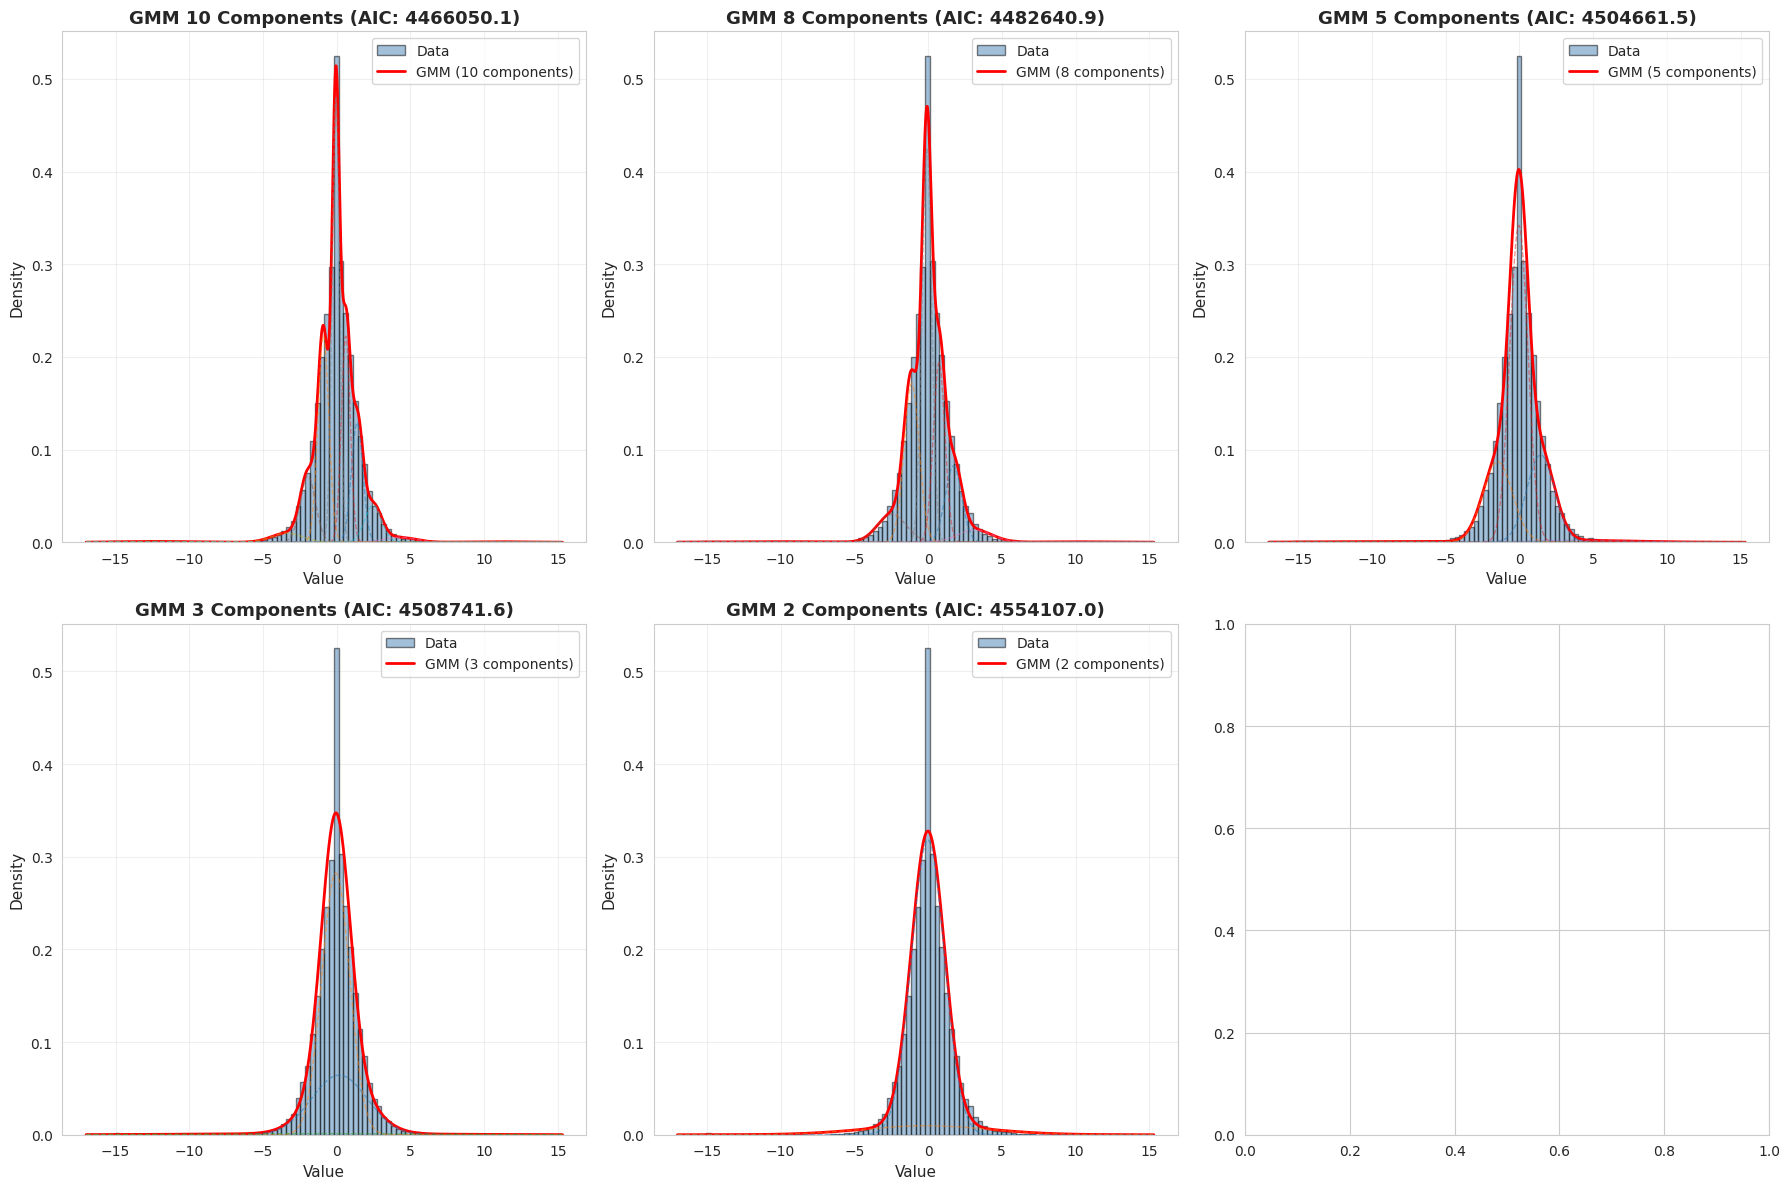

In [10]:
# Plot GMM fits
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, result in enumerate(gmm_results[:6]):
    ax = axes[idx]
    gmm = result['gmm']
    n_components = result['n_components']
    
    # Plot histogram
    ax.hist(all_values, bins=100, alpha=0.5, density=True, color='steelblue', edgecolor='black', label='Data')
    
    # Plot GMM
    x = np.linspace(all_values.min(), all_values.max(), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    ax.plot(x, pdf, 'r-', linewidth=2, label=f'GMM ({n_components} components)')
    
    # Plot individual components
    for i in range(n_components):
        component_pdf = gmm.weights_[i] * stats.norm.pdf(
            x.flatten(), 
            gmm.means_[i, 0], 
            np.sqrt(gmm.covariances_[i, 0, 0])
        )
        ax.plot(x, component_pdf, '--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Value', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f"GMM {n_components} Components (AIC: {result['aic']:.1f})", fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'gmm_fits.png', dpi=300, bbox_inches='tight')
plt.show()

## Compare All Models

In [11]:
# Create comparison table
print("="*80)
print("OVERALL COMPARISON (All Models)")
print("="*80)

comparison_data = []

# Add single-variable distributions
for result in fit_results:
    comparison_data.append({
        'Model': result['name'],
        'Type': 'Single Distribution',
        'AIC': result['aic'],
        'BIC': result['bic'],
        'KS Statistic': result['ks_stat']
    })

# Add GMMs
for result in gmm_results:
    comparison_data.append({
        'Model': f"GMM ({result['n_components']} components)",
        'Type': 'Mixture Model',
        'AIC': result['aic'],
        'BIC': result['bic'],
        'KS Statistic': None
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('AIC')

print("\n" + comparison_df.to_string(index=False))

print("\n" + "="*80)
print("BEST MODEL:")
print("="*80)
best_model = comparison_df.iloc[0]
print(f"  {best_model['Model']}")
print(f"  Type: {best_model['Type']}")
print(f"  AIC: {best_model['AIC']:.2f}")
print(f"  BIC: {best_model['BIC']:.2f}")

OVERALL COMPARISON (All Models)

              Model                Type          AIC          BIC  KS Statistic
GMM (10 components)       Mixture Model 4.466050e+06 4.466400e+06           NaN
 GMM (8 components)       Mixture Model 4.482641e+06 4.482918e+06           NaN
 GMM (5 components)       Mixture Model 4.504661e+06 4.504830e+06           NaN
 GMM (3 components)       Mixture Model 4.508742e+06 4.508838e+06           NaN
            Laplace Single Distribution 4.534683e+06 4.534707e+06      0.027321
 GMM (2 components)       Mixture Model 4.554107e+06 4.554167e+06           NaN
           Logistic Single Distribution 4.633191e+06 4.633215e+06      0.038641
             Cauchy Single Distribution 4.697011e+06 4.697035e+06      0.047585
             Normal Single Distribution 5.030303e+06 5.030327e+06      0.086730
         Log-Normal Single Distribution 5.042838e+06 5.042874e+06      0.086319
              Gamma Single Distribution 5.154286e+06 5.154322e+06      0.086847
       

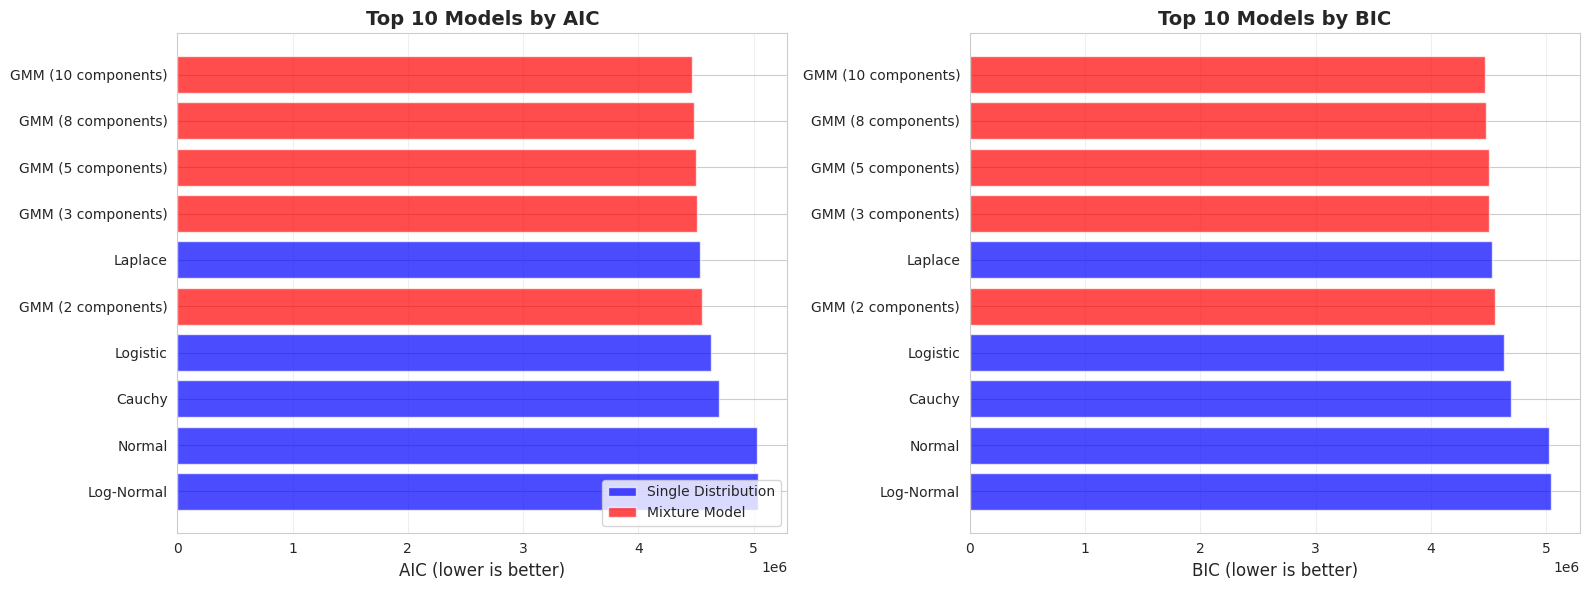

In [12]:
# Plot AIC/BIC comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 by AIC
top_10_aic = comparison_df.nsmallest(10, 'AIC')
colors = ['red' if 'GMM' in model else 'blue' for model in top_10_aic['Model']]
ax1.barh(range(len(top_10_aic)), top_10_aic['AIC'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(top_10_aic)))
ax1.set_yticklabels(top_10_aic['Model'], fontsize=10)
ax1.set_xlabel('AIC (lower is better)', fontsize=12)
ax1.set_title('Top 10 Models by AIC', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Top 10 by BIC
top_10_bic = comparison_df.nsmallest(10, 'BIC')
colors = ['red' if 'GMM' in model else 'blue' for model in top_10_bic['Model']]
ax2.barh(range(len(top_10_bic)), top_10_bic['BIC'], color=colors, alpha=0.7)
ax2.set_yticks(range(len(top_10_bic)))
ax2.set_yticklabels(top_10_bic['Model'], fontsize=10)
ax2.set_xlabel('BIC (lower is better)', fontsize=12)
ax2.set_title('Top 10 Models by BIC', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', alpha=0.7, label='Single Distribution'),
    Patch(facecolor='red', alpha=0.7, label='Mixture Model')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary and Recommendations

In [14]:
print("="*80)
print("SUMMARY AND RECOMMENDATIONS")
print("="*80)

best_single = comparison_df[comparison_df['Type'] == 'Single Distribution'].iloc[0]
best_mixture = comparison_df[comparison_df['Type'] == 'Mixture Model'].iloc[0]

print("\n1. BEST SINGLE DISTRIBUTION:")
print(f"   {best_single['Model']}")
print(f"   AIC: {best_single['AIC']:.2f}, BIC: {best_single['BIC']:.2f}")

print("\n2. BEST MIXTURE MODEL:")
print(f"   {best_mixture['Model']}")
print(f"   AIC: {best_mixture['AIC']:.2f}, BIC: {best_mixture['BIC']:.2f}")

print("\n3. OVERALL BEST MODEL:")
overall_best = comparison_df.iloc[0]
print(f"   {overall_best['Model']} ({overall_best['Type']})")
print(f"   AIC: {overall_best['AIC']:.2f}, BIC: {overall_best['BIC']:.2f}")

print("\n4. DATA CHARACTERISTICS:")
print(f"   - The data shows skewness of {skew(all_values):.4f}")
print(f"   - The data shows kurtosis of {kurtosis(all_values):.4f}")
if abs(skew(all_values)) < 0.5 and abs(kurtosis(all_values)) < 1:
    print("   - The distribution is approximately symmetric and mesokurtic")
elif skew(all_values) > 0.5:
    print("   - The distribution is right-skewed (positive skew)")
elif skew(all_values) < -0.5:
    print("   - The distribution is left-skewed (negative skew)")

print("\n5. RECOMMENDATIONS FOR SYNTHETIC DATA GENERATION:")
if 'Normal' in overall_best['Model']:
    print("   - Use a normal/Gaussian distribution")
    print(f"   - Parameters: mean={all_values.mean():.4f}, std={all_values.std():.4f}")
elif 'GMM' in overall_best['Model']:
    best_gmm = gmm_results[0]['gmm']
    print(f"   - Use a Gaussian Mixture Model with {best_gmm.n_components} components")
    print("   - Component parameters:")
    for i in range(best_gmm.n_components):
        print(f"     Component {i+1}: weight={best_gmm.weights_[i]:.4f}, "
              f"mean={best_gmm.means_[i,0]:.4f}, std={np.sqrt(best_gmm.covariances_[i,0,0]):.4f}")
else:
    print(f"   - Consider using {overall_best['Model']} distribution")

print("\n" + "="*80)

SUMMARY AND RECOMMENDATIONS

1. BEST SINGLE DISTRIBUTION:
   Laplace
   AIC: 4534683.25, BIC: 4534707.38

2. BEST MIXTURE MODEL:
   GMM (10 components)
   AIC: 4466050.13, BIC: 4466399.94

3. OVERALL BEST MODEL:
   GMM (10 components) (Mixture Model)
   AIC: 4466050.13, BIC: 4466399.94

4. DATA CHARACTERISTICS:
   - The data shows skewness of -1.0258
   - The data shows kurtosis of 19.0282
   - The distribution is left-skewed (negative skew)

5. RECOMMENDATIONS FOR SYNTHETIC DATA GENERATION:
   - Use a Gaussian Mixture Model with 10 components
   - Component parameters:
     Component 1: weight=0.1255, mean=1.3819, std=0.3879
     Component 2: weight=0.2067, mean=-0.9039, std=0.3699
     Component 3: weight=0.0046, mean=-12.4851, std=2.1610
     Component 4: weight=0.1678, mean=0.6147, std=0.3008
     Component 5: weight=0.0027, mean=10.9554, std=1.9482
     Component 6: weight=0.0928, mean=-1.9572, std=0.5171
     Component 7: weight=0.0143, mean=4.2475, std=1.0753
     Component 8: w